# Read Serial

In [196]:
import pandas as pd
import serial
import time
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from scipy.stats import pearsonr
from scipy.signal import resample as scipy_resample
import numpy as np

def read_serial_data(port, average_values_p1, var_window_size =20, var_threshold = 3000, resample_size = 100, baud_rate=115200, timeout=1, duration=10):
    
    readings = {}
    global ser
    
    # init_real_time_plot()  # Ensure you have initialized a Plotly FigureWidget globally
    ser = serial.Serial(port, baud_rate, timeout=timeout)
    end_time = time.time() + duration
    value_index = 0  # Cycle through 0 (x), 1 (y), 2 (z)
    sample_index = 0  # Increment for each new set of x, y, z values

    lst_x1 = []
    lst_y1 = []
    lst_z1 = []

    lst_x3 = []
    lst_y3 = []
    lst_z3 = []

    lst_var = []
    #lst_test = []
    test_resampled = []
    in_segment = False
    segments = []
    seg_store = []
    store = []


    try:
        # while True: # if want to read data continuously
        while time.time() < end_time:  # Continuously read and plot data
            if ser.in_waiting > 0:
                data = ser.readline().decode('utf-8').strip()
                if data:
                    try:
                        value = int(data)
                        #print(value)
                        
                        #if value_index == 0:  # X1 value                                
                        #    lst_x1.append(value)
                        #    print(value)
                            
                        if value_index == 0:  # Y1 value
                            
                            lst_y1.append(value)    
                            #print(value)
                            
                            if len(lst_y1)> var_window_size:
                                #print('inloop')
                                lst_var.append(np.var(lst_y1[len(lst_y1)-var_window_size:]))
                                #variances = np.array([np.var(lst_y1[i:i + 10]) for i in range(len(lst_y1) - 10 + 1)])
                                
                            if in_segment and lst_var[-1] > var_threshold:
                                #print('storing')
                                seg_store.append(lst_y1[-10])
                                               
                                               
                            if in_segment and lst_var[-1] <= var_threshold:
                                in_segment = False
                                segments.append(seg_store)
                                seg_store = []
                                test_resampled.append(scipy_resample(segments[-1], resample_size))
                                pearson_coefficient, _ = pearsonr(average_values_p1, test_resampled[-1])
                                print('PEARSON COEFFICIENT:', pearson_coefficient)
                                if pearson_coefficient > 0.9:
                                    print('POSE 1 DETECTED!!')
                                               
                            if not in_segment and len(lst_var)>20:
                                if all(x < 4000 for x in lst_var[len(lst_var)-20:]):
                                    #print('in here', lst_var[-10:])
                                    store.append(lst_var[-1])
                                    if lst_var[-1] > var_threshold:
                                        #print('in here 2')
                                        seg_store.append(lst_y1[-10])
                                        in_segment = True   
                                
                                        
                                        
                        #elif value_index == 2:  
                         #   lst_z1.append(value)    
                        #elif value_index == 3:  
                         #   lst_x3.append(value)
                        #elif value_index == 4:  
                        #    lst_y3.append(value)
                        #elif value_index == 5:  
                         #   lst_z3.append(value)
                        
                        value_index = (value_index + 1) % 2  # Cycle through 0, 1, 2
                    except ValueError:
                        pass  # Ignore non-integer values

       #readings['x1'] = lst_x1
        readings['y1'] = lst_y1
        #readings['z1'] = lst_z1

        #readings['x3'] = lst_x3
        #readings['y3'] = lst_y3
        #readings['z3'] = lst_z3

        readings['y1_var'] = lst_var    
        readings['y1_resampled'] = test_resampled      
        readings['y1_recorded'] = segments
        #print('last element', store)
        #print(segments)
                                               
    finally:
        ser.close()
        
    
    return readings


In [197]:
# import the benchmark
p1_benchmark_temp = pd.read_csv('benchmark_p1.csv').transpose()
p1_benchmark = p1_benchmark_temp[0].tolist()

In [198]:
#port = '/dev/tty.usbmodem21402'  # Example for Linux/Mac. Use 'COM#' for Windows.
port = 'COM9'
data = read_serial_data(port, p1_benchmark, duration=20)  # Read data for 10 seconds

KeyboardInterrupt: 

# Plot recorded data

Text(0.5, 1.0, 'recording')

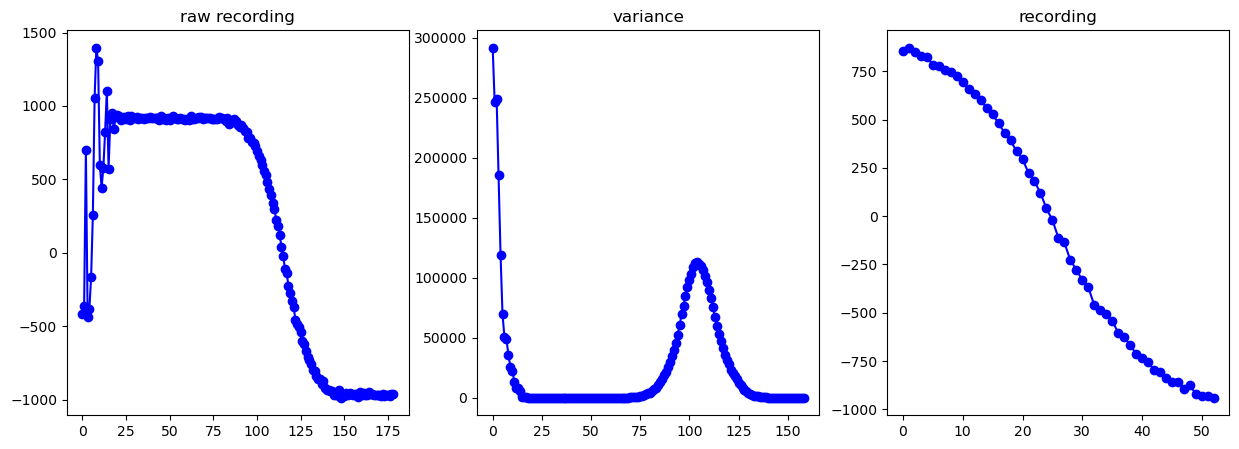

In [192]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) 

axs[0].plot(data['y1'], marker='o', linestyle='-', color='b')
axs[0].set_title('raw recording')

axs[1].plot(data['y1_var'], marker='o', linestyle='-', color='b')
axs[1].set_title('variance')

axs[2].plot(data['y1_recorded'][0], marker='o', linestyle='-', color='b')
axs[2].set_title('recording')


# Troubleshooting

In [175]:
indexes = [index for index, value in enumerate(data['y1_var']) if value > 3400]

In [178]:
corresponding_values = [data['y1'][index-10] for index in indexes]

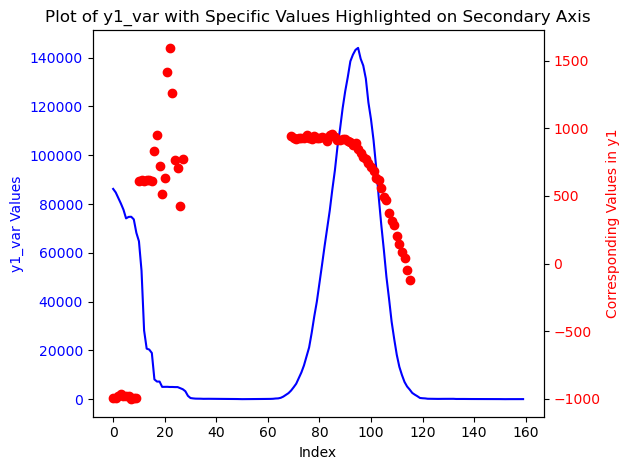

In [179]:
fig, ax1 = plt.subplots()
# Plotting data['y1_var'] on the first y-axis
ax1.plot(data['y1_var'], label='y1_var', color='blue')
ax1.set_xlabel('Index')
ax1.set_ylabel('y1_var Values', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a second y-axis that shares the same x-axis
ax2 = ax1.twinx()
ax2.scatter(indexes, corresponding_values, color='red', label='Values > 3400')
ax2.set_ylabel('Corresponding Values in y1', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Adding a title and adjusting the layout
plt.title('Plot of y1_var with Specific Values Highlighted on Secondary Axis')
fig.tight_layout()

# Showing the plot
plt.show()

## For exporting of sensor readings

In [666]:
import pandas as pd
df = pd.DataFrame({k : pd.Series(v) for k, v in data.items()})

df.to_csv('pose2.csv')

In [ ]:
store.append(lst_var[-1])from IPython.display import display

def init_real_time_plot():
    # global fig_x, fig_y, fig_z
    global fig_y, fig_z

    # Initialize figures with two traces each: actual values and moving averages
    # fig_x = go.FigureWidget(data=[
    #     go.Scatter(x=[], y=[], mode='lines+markers', name='X Values'),
    #     go.Scatter(x=[], y=[], mode='lines', name='X Moving Avg', line=dict(color='red'))])
    fig_y = go.FigureWidget(data=[
        go.Scatter(x=[], y=[], mode='lines+markers', name='Y Values'),
        go.Scatter(x=[], y=[], mode='lines', name='Y Moving Avg', line=dict(color='red'))])
    fig_z = go.FigureWidget(data=[
        go.Scatter(x=[], y=[], mode='lines+markers', name='Z Values'),
        go.Scatter(x=[], y=[], mode='lines', name='Z Moving Avg', line=dict(color='red'))])

    # Set titles and display the figures
    # fig_x.update_layout(title_text='Real-Time X Values')
    fig_y.update_layout(title_text='Real-Time Y1 Values')
    fig_z.update_layout(title_text='Real-Time Y3 Values')
    # display(fig_x, fig_y, fig_z)
    display(fig_y, fig_z)




In [ ]:
def send_alert_to_microbit(serial_connection, message):
    """
    Sends an alert message to the microbit via the serial connection.

    Args:
    - serial_connection: The open serial connection to the microbit.
    - message: The message to send as a string.
    """
    serial_connection.write(message.encode())
    # serial_connection.close()